# LSTM - bert64

- **Training set**: LO_SARD102(0.6 split)
- **Test/Validation set:** LO_SARD102 (0.2 split)
- **Features**: bert sequence (64)
- **Class imbalance processing**: SMOTE

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from helper_functions import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

X = numpy.load('/mnt/md0/user/scheuererra68323/LOSARD102_bert64_X.npy')
y = pd.read_hdf('/mnt/md0/user/scheuererra68323/LOSARD102_bert64_y.h5').is_vulnerable.values

X_train, X_test, Y_train, Y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=5)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, stratify=Y_train, test_size=0.25, random_state=10)

del X
del y


# oversample class 1
X_train, Y_train = oversample_smote(np.reshape(X_train, (-1, 64*768)), Y_train )

X_train = np.reshape( X_train, (-1, 64, 768) )

print("class counts oversampled data set:", (X_train.shape[0], Y_train.shape[0]))

print(X_train.shape)
print(Y_train.shape)
print(X_val.shape)
print(Y_val.shape)
print(X_test.shape)
print(Y_test.shape)

imbalanced_learn version  0.7.0
Counter output before SMOTE: Counter({0: 11742, 1: 231})
Counter output after SMOTE: Counter({0: 11742, 1: 11742})
class counts oversampled data set: (23484, 23484)
(23484, 64, 768)
(23484,)
(3991, 64, 768)
(3991,)
(3991, 64, 768)
(3991,)


## Variant 1

In [2]:
def oversample_smote(X, y):
    from imblearn.over_sampling import SMOTE
    # summarize the new class distribution
    counter = Counter(y)
    print("Counter output before SMOTE:", counter)
    
    # transform the dataset
    oversample = SMOTE()
    X, y = oversample.fit_resample(X, y)
    
    # summarize the new class distribution
    counter = Counter(y)
    print("Counter output after SMOTE:", counter)
    return X, y


def run_classifier(_X_train, _Y_train, _X_val, _Y_val):
    
    model = keras.Sequential()
    model.add(layers.LSTM(512, input_shape=(_X_train.shape[1], _X_train.shape[2]), 
                          return_sequences=True))
    model.add(layers.Dropout(0.1))
    model.add( layers.TimeDistributed(layers.Dense(256)) )
    model.add(layers.Flatten())
    model.add(layers.Dense(128))
    model.add(layers.Dense(64))
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy']
                 )
    
    
    history = model.fit(_X_train, _Y_train,
                        batch_size=512,
                        epochs=4,
                        verbose=True,
                        validation_data=(_X_val, _Y_val)
                        )
    
    return model, history


model, history = run_classifier(X_train, Y_train, X_val, Y_val)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64, 512)           2623488   
_________________________________________________________________
dropout (Dropout)            (None, 64, 512)           0         
_________________________________________________________________
time_distributed (TimeDistri (None, 64, 256)           131328    
_________________________________________________________________
flatten (Flatten)            (None, 16384)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               2097280   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 6

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3914
           1       0.96      1.00      0.98        77

    accuracy                           1.00      3991
   macro avg       0.98      1.00      0.99      3991
weighted avg       1.00      1.00      1.00      3991

Confusion matrix:
[[3911    3]
 [   0   77]]

Confusion matrix (Percentages):
[[9.7995e+01 7.5000e-02]
 [0.0000e+00 1.9290e+00]]

Metrics:
Sensitivity (TPR): 1.000000
Specifity (TNR):   0.999234

FPR: 0.000766
FNR: 0.000000

Balanced accuracy: 0.999617

Test loss:	0.002091
Test accuracy:	0.999248


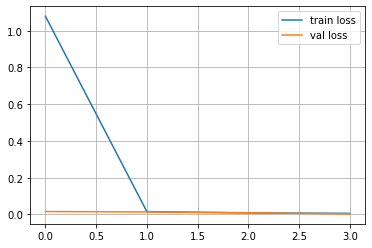

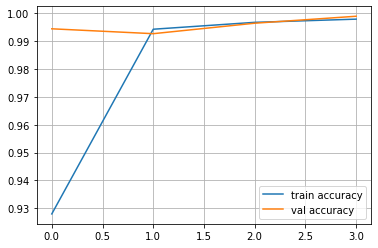

In [3]:
def evaluate_classifier(_model, _history):
    Y_pred = numpy.round(_model.predict(X_test))

    print(classification_report(Y_test, Y_pred))
    print_metrics(confusion_matrix(Y_test, Y_pred), Y_test)
    print()
    score = _model.evaluate(X_test, Y_test, verbose=False)
    print('Test loss:\t{:.6f}'.format(score[0]))
    print('Test accuracy:\t{:.6f}'.format(score[1]))

    plot_loss(_history)
    plot_accuracy(_history)


evaluate_classifier(model, history)

In [9]:
model.save('LSTM_Var1_bert64_SMOTE')
model.save('LSTM_Var1_bert64_SMOTE.h5')

INFO:tensorflow:Assets written to: LSTM_Var1_bert64_SMOTE/assets


## Variant 2

In [5]:
def run_classifier(_X_train, _Y_train, _X_val, _Y_val):
    
    model = keras.Sequential()
    model.add(layers.LSTM(64, input_shape=(_X_train.shape[1], _X_train.shape[2]), 
                          return_sequences=True))
    model.add(layers.Dropout(0.1))
    model.add(layers.LSTM(16, return_sequences=True))
    model.add( layers.TimeDistributed(layers.Dense(16)) )
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))

    model.summary()
    model.compile(loss='binary_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy']
                 )
    
    
    history = model.fit(_X_train, _Y_train,
                        batch_size=512,
                        epochs=4,
                        verbose=True,
                        validation_data=(_X_val, _Y_val)
                        )
    
    return model, history


modelv2, historyv2 = run_classifier(X_train, Y_train, X_val, Y_val)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 64, 64)            213248    
_________________________________________________________________
dropout_1 (Dropout)          (None, 64, 64)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 64, 16)            5184      
_________________________________________________________________
time_distributed_1 (TimeDist (None, 64, 16)            272       
_________________________________________________________________
flatten_1 (Flatten)          (None, 1024)              0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 1025      
Total params: 219,729
Trainable params: 219,729
Non-trainable params: 0
________________________________________________

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      3914
           1       0.95      1.00      0.97        77

    accuracy                           1.00      3991
   macro avg       0.98      1.00      0.99      3991
weighted avg       1.00      1.00      1.00      3991

Confusion matrix:
[[3910    4]
 [   0   77]]

Confusion matrix (Percentages):
[[97.97   0.1  ]
 [ 0.     1.929]]

Metrics:
Sensitivity (TPR): 1.000000
Specifity (TNR):   0.998978

FPR: 0.001022
FNR: 0.000000

Balanced accuracy: 0.999489

Test loss:	0.002409
Test accuracy:	0.998998


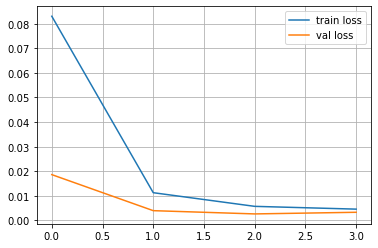

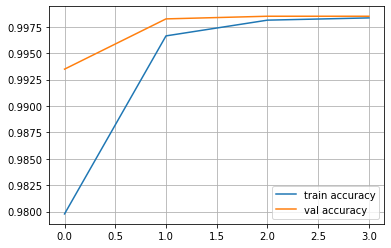

In [6]:
evaluate_classifier(modelv2, historyv2)

In [8]:
modelv2.save('LSTM_Var2_bert64_SMOTE')
modelv2.save('LSTM_Var2_bert64_SMOTE.h5')

INFO:tensorflow:Assets written to: LSTM_Var2_bert64_SMOTE/assets
